## Import required packages

In [1]:
import os
import json
from datetime import datetime
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

import pystac
from pystac_client import Client
from odc import stac as odc_stac
from odc.geo.geobox import GeoBox
from affine import Affine

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

## Create STAC client and connecting to the server

In [2]:
stac_api = "https://dev.stac.eodc.eu/api/v1"
client = Client.open(stac_api)

collection_id="AI4SAR_SIG0"

## Search items via STAC client

In [16]:
collection_id="AI4SAR_SIG0"

bbox = [15.6, 47.7, 16.6, 48.7]  # [lon_min, lat_min, lon_max, lat_max]
start_date = "2023-01-01"
end_date = "2023-12-31"

query_prop = {
    "sat:relative_orbit": {"eq": 146,}
        }

query = client.search(bbox=bbox,
                        collections=[collection_id],
                        datetime=f"{start_date}/{end_date}",
                        query = query_prop,
                        )
#q_items = list(query.get_items())
q_items = sorted(query.get_items(), key=lambda x: x.id)

In [17]:
for x in q_items: print (x.id)

SIG0_20231109T165058_A146_EU020M_E051N015T3_S1AIWGRDH
SIG0_20231109T165123_A146_EU020M_E051N015T3_S1AIWGRDH
SIG0_20231121T165058_A146_EU020M_E051N015T3_S1AIWGRDH
SIG0_20231121T165123_A146_EU020M_E051N015T3_S1AIWGRDH
SIG0_20231203T165058_A146_EU020M_E051N015T3_S1AIWGRDH
SIG0_20231203T165123_A146_EU020M_E051N015T3_S1AIWGRDH
SIG0_20231215T165057_A146_EU020M_E051N015T3_S1AIWGRDH
SIG0_20231215T165122_A146_EU020M_E051N015T3_S1AIWGRDH
SIG0_20231227T165056_A146_EU020M_E051N015T3_S1AIWGRDH
SIG0_20231227T165121_A146_EU020M_E051N015T3_S1AIWGRDH


## Load STAC Items into xarray Dataset using odc.stac

In [7]:
collection_id="AI4SAR_SIG0"

bbox = [15.6, 47.7, 16.6, 48.7]  # [lon_min, lat_min, lon_max, lat_max]
start_date = "2023-01-01"
end_date = "2023-10-31"

query = client.search(bbox=bbox,
                        collections=[collection_id],
                        datetime=f"{start_date}/{end_date}",
                        )
#q_items = list(query.get_items())
q_items = sorted(query.get_items(), key=lambda x: x.id)

In [8]:
q_items

[<Item id=SIG0_20230418T050210_D124_EU020M_E051N015T3_S1AIWGRDH>,
 <Item id=SIG0_20230512T050211_D124_EU020M_E051N015T3_S1AIWGRDH>,
 <Item id=SIG0_20230617T050213_D124_EU020M_E051N015T3_S1AIWGRDH>]

In [9]:
q_items[0].assets

{'VH': <Asset href=https://data.eodc.eu/collections/AI4SAR_SIG0/EQUI7_EU020M/E051N015T3/SIG0_20230418T050210__VH_D124_E051N015T3_EU020M_V1M1R2_S1AIWGRDH_TUWIEN.tif>,
 'VV': <Asset href=https://data.eodc.eu/collections/AI4SAR_SIG0/EQUI7_EU020M/E051N015T3/SIG0_20230418T050210__VV_D124_E051N015T3_EU020M_V1M1R2_S1AIWGRDH_TUWIEN.tif>,
 'thumbnail': <Asset href=https://data.eodc.eu/collections/AI4SAR_SIG0/EQUI7_EU020M/E051N015T3/SIG0_20230418T050210__VV_D124_E051N015T3_EU020M_V1M1R2_S1AIWGRDH_TUWIEN.tif/thumbnail>}

In [10]:
#bands = ("VV"), "VH")
bands = ("VV", "VH")
crs = "EPSG:4326"
bbox = [15.6, 47.7, 16.6, 48.7]
res = 0.00018 # 20 meter in degree
sig0_ds = odc_stac.stac_load(q_items,
                        bands=bands,
                        crs=crs,
                        resolution=res,
                        bbox=bbox,
                        use_overviews=False,
                        )

In [91]:
#sig0_ds.to_netcdf("/mnt/c/Users/SenmaoCao/work/projects/ai4sar/tmp/vv.nc")

In [11]:
def scale_image(arr, nodata, vmin=None, vmax=None):
    
    v_idx = arr!=nodata
    
    v = arr[v_idx]

    if vmin is None:
        
        vmin = np.min(v)
    if vmax is None:
        vmax = np.max(v)
    
    out = np.copy(arr)
    # scale between 1 and 255 and leave 0 for nodata
    out = (out-vmin) * (254/(vmax-vmin)) + 1
    out[~v_idx] = 0

    return out.astype(np.uint8)

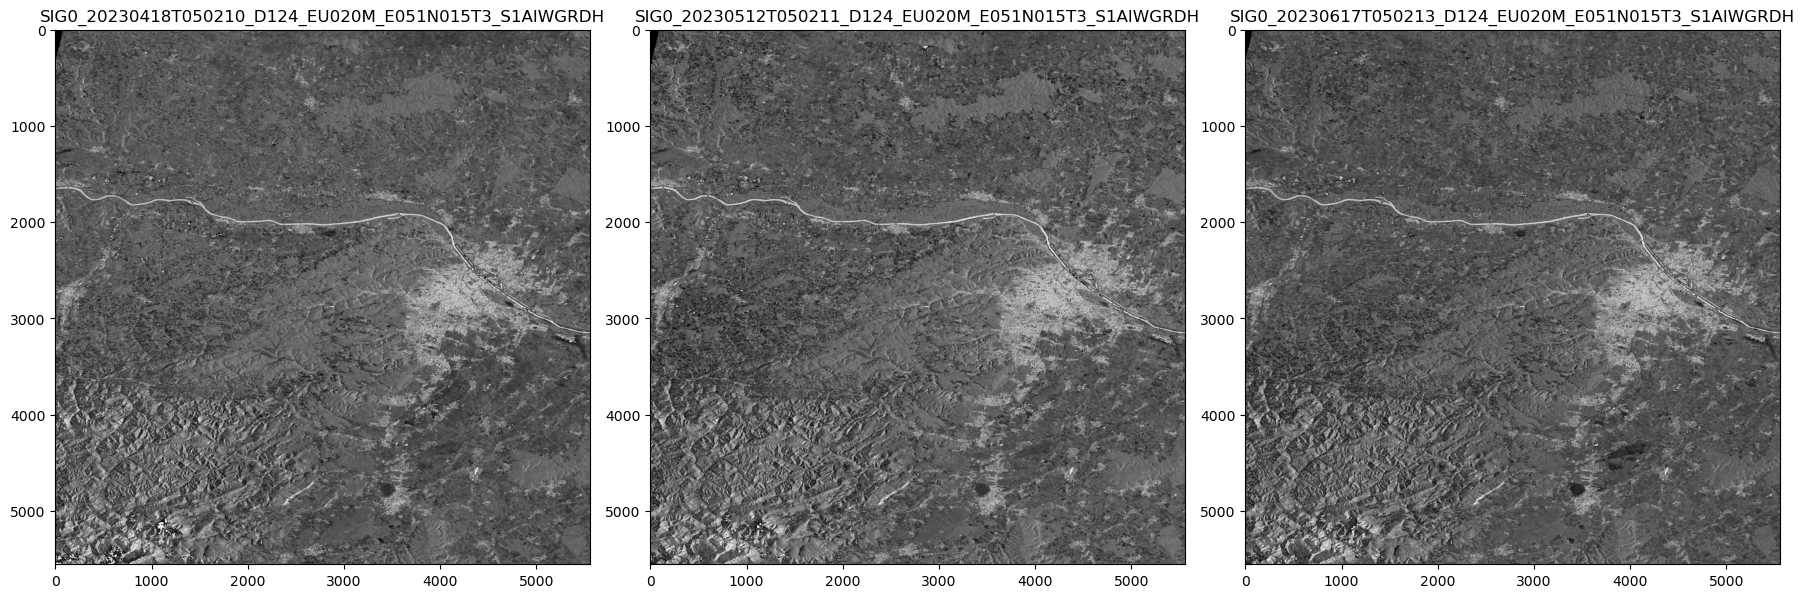

In [12]:
fig1 = plt.figure(figsize=(18, 6))
#fig1.suptitle('AI4SAR Sigma0 VV', fontsize=16)
nodata = -9999

for i in range(3):
    
    img = sig0_ds.VV[i,:,:].to_numpy()
    name = q_items[i].id

    gray_img = scale_image(img, nodata, vmin=-170, vmax=20)

    ax = fig1.add_subplot(1, 3, i+1)
    ax.set_title(name)
    ax.imshow(gray_img, cmap='gray')


plt.tight_layout()

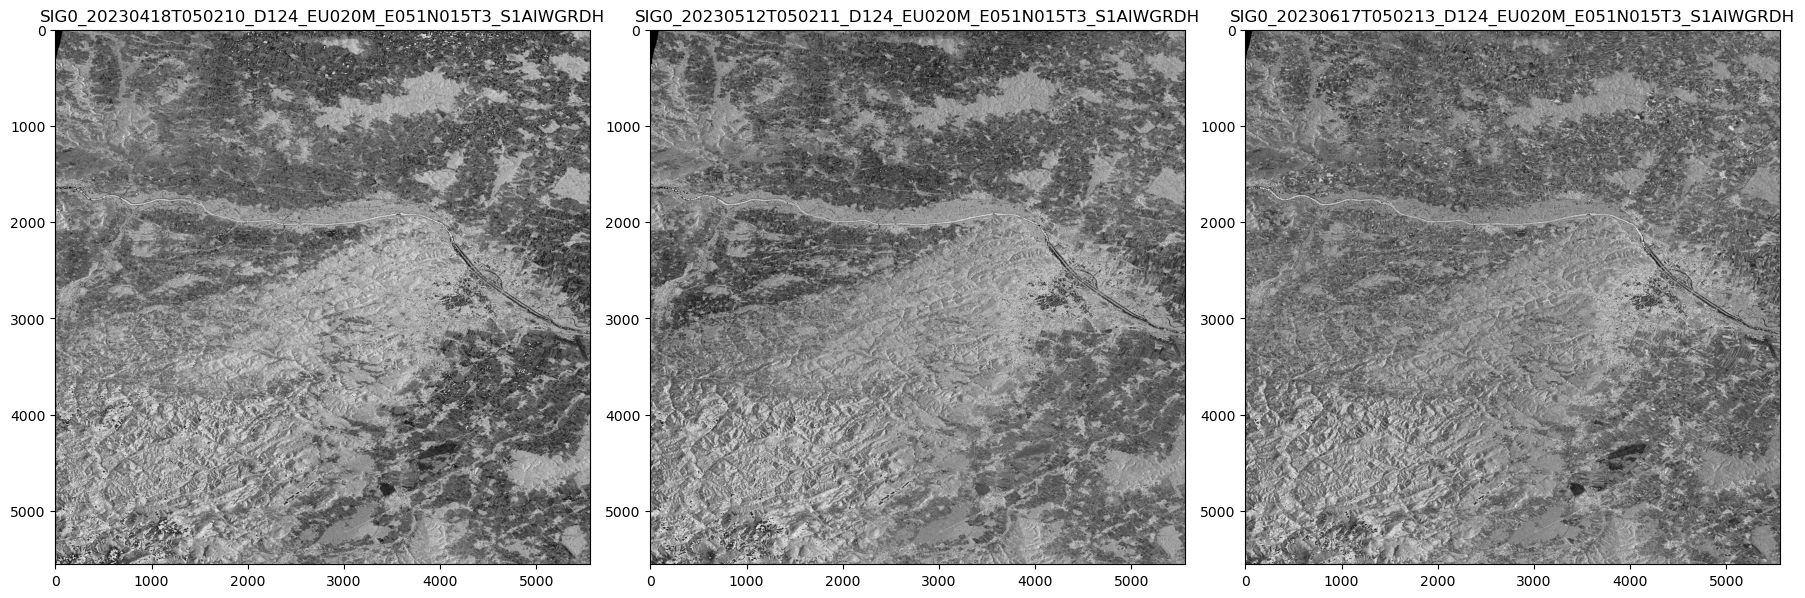

In [13]:
fig1 = plt.figure(figsize=(18, 6))
#fig1.suptitle('AI4SAR Sigma0 VV', fontsize=16)
nodata = -9999

for i in range(3):
    
    img = sig0_ds.VH[i,:,:].to_numpy()
    name = q_items[i].id

    gray_img = scale_image(img, nodata, vmin=-240, vmax=-100)

    ax = fig1.add_subplot(1, 3, i+1)
    ax.set_title(name)
    ax.imshow(gray_img, cmap='gray')


plt.tight_layout()

### Load data in orginal CRS

In [14]:
bands = ("VV")
org_crs = q_items[0].properties["proj:wkt2"] #EU_E051N015T3
west, south, east, north = 5240000, 1580000, 5320000, 1640000
org_res = 20
shape = (int((north-south) / 20), int((east-west) / 20))
gbox = GeoBox(shape, crs=org_crs, affine=Affine(org_res, 0, west, 0, -org_res, north))


sig0_org_ds = odc_stac.stac_load(q_items,
                        bands=bands,
                        geobox=gbox,
                        use_overviews=False,
                        )

In [130]:
# sig0_org_ds.to_netcdf("/mnt/c/Users/SenmaoCao/work/projects/ai4sar/tmp/org_vv.nc")

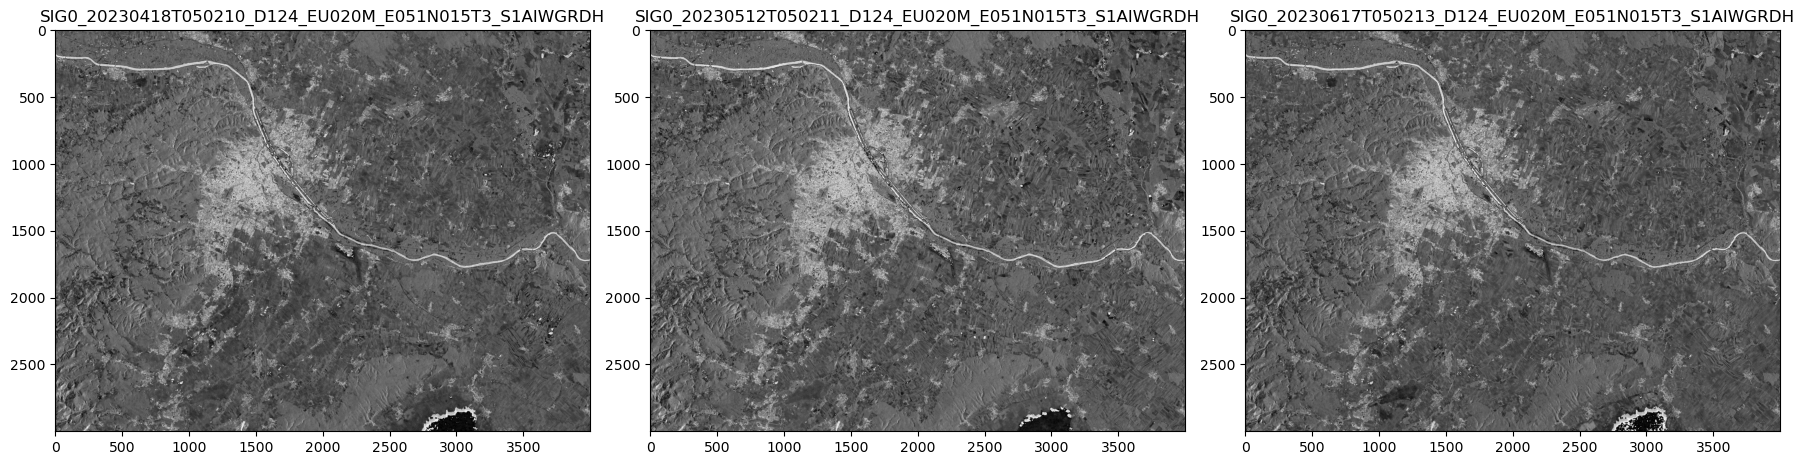

In [15]:
fig1 = plt.figure(figsize=(18, 6))
#fig1.suptitle('AI4SAR Sigma0 VV', fontsize=16)
nodata = -9999

for i in range(3):
    
    img = sig0_org_ds.VV[i,:,:].to_numpy()
    name = q_items[i].id

    gray_img = scale_image(img, nodata, vmin=-170, vmax=20)

    ax = fig1.add_subplot(1, 3, i+1)
    ax.set_title(name)
    ax.imshow(gray_img, cmap='gray')


plt.tight_layout()

## Exploring AI4SAR data for your applications ......